In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent as AgentDQN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.agent.lstm import Agent as AgentLSTM
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from rex import init_logger
from sympy import symbols, sqrt, simplify, expand, nsimplify, parse_expr, sympify
import sympy
import cProfile, pstats, io
from pstats import SortKey
from rl_equation_solver.agent.a2c import Agent as AgentA2C

In [3]:
init_logger(__name__, log_level="INFO")
init_logger("rl_equation_solver", log_level="INFO")

<Logger rl_equation_solver (INFO)>

In [4]:
# plot reward distribution
def plot_reward_dist(env):
    _, ax = plt.subplots(1, 1)
    ax.hist(env.best_history["reward"])
    ax.set_ylabel("Count")
    ax.set_xlabel("Reward")
    plt.show()


# plot complexity, loss, reward
def plot_trends(env):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax = axes.flatten()
    history = env.total_history
    x = np.arange(len(history["ep"]))

    y = history["complexity"]
    a, b = np.polyfit(x, y, 1)
    ax[0].scatter(x, y)
    ax[0].plot(a * x + b, color="r")

    y = history["loss"]
    mask = np.array([i for i, v in enumerate(y) if not np.isnan(v)])
    mask = slice(mask[0], mask[-1] + 1)
    a, b = np.polyfit(x[mask], y[mask], 1)
    ax[1].scatter(x[mask], y[mask])
    ax[1].plot(x[mask], a * x[mask] + b, color="r")

    y = history["reward"]
    a, b = np.polyfit(x, y, 1)
    ax[2].scatter(x, y)
    ax[2].plot(a * x + b, color="r")

    y = history["loop_step"]
    a, b = np.polyfit(x, y, 1)
    ax[3].scatter(x, y)
    ax[3].plot(a * x + b, color="r")

    ax[0].set_title("Complexity")
    ax[1].set_title("Loss")
    ax[2].set_title("Reward")
    ax[3].set_title("Steps")

    plt.show()

## Initialize Env and Agent ##
### Agent can be AgentGCN, AgentLSTM, AgentDQN ###

In [5]:
env = Env(
    order=2, config={"reward_function": "diff_loss_reward", "fill_memory_steps": 100}
)

INFO - 2023-04-25 07:16:03,155 [algebraic.py:110] : Initializing environment with order=2, |S| = 11 x 128 = 1408
INFO - 2023-04-25 07:16:03,156 [algebraic.py:115] : Using reward function: diff_loss_reward.


In [6]:
agent = AgentA2C(env=env)  # , config={'tau': 0.05, 'eps_end': 0.05})

INFO - 2023-04-24 18:11:04,432 [base.py:92] : Initialized Agent with config: {'batch_size': 32, 'gamma': 0.9, 'eps_start': 0.9, 'eps_end': 0.05, 'eps_decay_steps': 1000, 'eps_decay': None, 'epsilon_threshold': None, 'tau': 0.05, 'learning_rate': 0.0003, 'hidden_size': 64, 'memory_cap': 10000, 'fill_memory_steps': 100, 'reset_steps': 100, 'state_dim': 128, 'feature_num': 100, 'grad_clip': 10, 'reward_function': 'diff_loss_reward', 'max_solution_steps': 2000, 'device': 'cuda:0'}


## Train Agent ##

In [16]:
for _ in range(1):
    agent.train(50)

INFO - 2023-04-24 20:07:40,195 [base.py:263] : Running training routine for 50 episodes in eval=False mode.


0it [00:00, ?it/s]c:\users\bbent\repos\rl-equation-solver\rl_equation_solver\agent\base.py:719: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
{'ep': '70  ', 'step': '40946', 'loop_step': '1186', 'complexity': '1.80e+01 ', 'loss': '-3.07e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 0it [00:59, ?it/s]   

INFO - 2023-04-24 20:08:39,781 [algebraic.py:476] : {'ep': '70  ', 'step': '40947', 'loop_step': '1187', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '71  ', 'step': '41455', 'loop_step': '507 ', 'complexity': '1.80e+01 ', 'loss': '-3.11e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 1it [01:23, 59.59s/it]   

INFO - 2023-04-24 20:09:03,977 [algebraic.py:476] : {'ep': '71  ', 'step': '41456', 'loop_step': '508 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '72  ', 'step': '41980', 'loop_step': '523 ', 'complexity': '1.80e+01 ', 'loss': '1.15e+02 ', 'reward': '6.00e+00 ', 'previous_state': '1 - a1              ', 'state': '-a1                 '}: : 2it [01:50, 38.77s/it]   

INFO - 2023-04-24 20:09:30,560 [algebraic.py:476] : {'ep': '72  ', 'step': '41981', 'loop_step': '524 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '73  ', 'step': '42049', 'loop_step': '67  ', 'complexity': '1.80e+01 ', 'loss': '-2.99e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 3it [01:53, 33.20s/it]

INFO - 2023-04-24 20:09:34,127 [algebraic.py:476] : {'ep': '73  ', 'step': '42050', 'loop_step': '68  ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.94e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '74  ', 'step': '42069', 'loop_step': '18  ', 'complexity': '1.80e+01 ', 'loss': '-3.11e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 4it [01:54, 21.50s/it]

INFO - 2023-04-24 20:09:35,091 [algebraic.py:476] : {'ep': '74  ', 'step': '42070', 'loop_step': '19  ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '2.30e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '75  ', 'step': '43720', 'loop_step': '1649', 'complexity': '1.80e+01 ', 'loss': '-2.75e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 5it [03:18, 14.10s/it]     

INFO - 2023-04-24 20:10:58,224 [algebraic.py:476] : {'ep': '75  ', 'step': '43721', 'loop_step': '1650', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '76  ', 'step': '44769', 'loop_step': '1047', 'complexity': '1.80e+01 ', 'loss': '-2.88e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 6it [04:12, 37.57s/it] 

INFO - 2023-04-24 20:11:52,575 [algebraic.py:476] : {'ep': '76  ', 'step': '44770', 'loop_step': '1048', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '77  ', 'step': '45013', 'loop_step': '242 ', 'complexity': '1.80e+01 ', 'loss': '-3.10e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 7it [04:23, 43.06s/it]   

INFO - 2023-04-24 20:12:04,035 [algebraic.py:476] : {'ep': '77  ', 'step': '45014', 'loop_step': '243 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.84e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '78  ', 'step': '45270', 'loop_step': '255 ', 'complexity': '1.80e+01 ', 'loss': '1.43e+02 ', 'reward': '8.00e+00 ', 'previous_state': '-a1 - 1             ', 'state': '-a1                 '}: : 8it [04:35, 33.00s/it]

INFO - 2023-04-24 20:12:15,779 [algebraic.py:476] : {'ep': '78  ', 'step': '45271', 'loop_step': '256 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.84e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '79  ', 'step': '46067', 'loop_step': '795 ', 'complexity': '1.80e+01 ', 'loss': '-2.18e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 9it [05:14, 26.35s/it]  

INFO - 2023-04-24 20:12:54,602 [algebraic.py:476] : {'ep': '79  ', 'step': '46068', 'loop_step': '796 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '80  ', 'step': '46156', 'loop_step': '87  ', 'complexity': '1.80e+01 ', 'loss': '-3.03e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 10it [05:18, 30.20s/it]

INFO - 2023-04-24 20:12:59,025 [algebraic.py:476] : {'ep': '80  ', 'step': '46157', 'loop_step': '88  ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.91e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '81  ', 'step': '47417', 'loop_step': '1259', 'complexity': '1.80e+01 ', 'loss': '-3.02e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 11it [06:20, 22.31s/it]   

INFO - 2023-04-24 20:14:01,143 [algebraic.py:476] : {'ep': '81  ', 'step': '47418', 'loop_step': '1260', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '82  ', 'step': '47419', 'loop_step': '0   ', 'complexity': '1.80e+01 ', 'loss': '-3.04e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 12it [06:20, 34.42s/it]

INFO - 2023-04-24 20:14:01,207 [algebraic.py:476] : {'ep': '82  ', 'step': '47420', 'loop_step': '1   ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '6.80e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '83  ', 'step': '47723', 'loop_step': '302 ', 'complexity': '1.80e+01 ', 'loss': '-3.01e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 13it [06:35, 34.42s/it] 

INFO - 2023-04-24 20:14:15,858 [algebraic.py:476] : {'ep': '83  ', 'step': '47724', 'loop_step': '303 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.83e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '84  ', 'step': '47907', 'loop_step': '182 ', 'complexity': '1.80e+01 ', 'loss': '-3.02e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 14it [06:44, 21.84s/it]

INFO - 2023-04-24 20:14:24,335 [algebraic.py:476] : {'ep': '84  ', 'step': '47908', 'loop_step': '183 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.85e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '85  ', 'step': '47947', 'loop_step': '38  ', 'complexity': '1.80e+01 ', 'loss': '-3.05e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 15it [06:45, 18.51s/it]

INFO - 2023-04-24 20:14:26,142 [algebraic.py:476] : {'ep': '85  ', 'step': '47948', 'loop_step': '39  ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '2.05e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '86  ', 'step': '48513', 'loop_step': '564 ', 'complexity': '1.80e+01 ', 'loss': '-3.11e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 16it [07:12, 14.12s/it]  

INFO - 2023-04-24 20:14:52,777 [algebraic.py:476] : {'ep': '86  ', 'step': '48514', 'loop_step': '565 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '87  ', 'step': '48631', 'loop_step': '116 ', 'complexity': '1.80e+01 ', 'loss': '-3.03e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 17it [07:18, 17.53s/it]  

INFO - 2023-04-24 20:14:58,327 [algebraic.py:476] : {'ep': '87  ', 'step': '48632', 'loop_step': '117 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.88e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '88  ', 'step': '48636', 'loop_step': '3   ', 'complexity': '1.80e+01 ', 'loss': '-3.08e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 18it [07:18, 14.17s/it]

INFO - 2023-04-24 20:14:58,492 [algebraic.py:476] : {'ep': '88  ', 'step': '48637', 'loop_step': '4   ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '3.80e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '89  ', 'step': '49241', 'loop_step': '603 ', 'complexity': '1.80e+01 ', 'loss': '-3.08e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 19it [07:46, 10.17s/it]  

INFO - 2023-04-24 20:15:26,868 [algebraic.py:476] : {'ep': '89  ', 'step': '49242', 'loop_step': '604 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '90  ', 'step': '49382', 'loop_step': '139 ', 'complexity': '1.80e+01 ', 'loss': '-2.95e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 20it [07:53, 15.45s/it]

INFO - 2023-04-24 20:15:33,489 [algebraic.py:476] : {'ep': '90  ', 'step': '49383', 'loop_step': '140 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.87e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '91  ', 'step': '49597', 'loop_step': '213 ', 'complexity': '1.80e+01 ', 'loss': '-3.11e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 21it [08:03, 12.86s/it]

INFO - 2023-04-24 20:15:43,897 [algebraic.py:476] : {'ep': '91  ', 'step': '49598', 'loop_step': '214 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.85e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '92  ', 'step': '49724', 'loop_step': '125 ', 'complexity': '1.80e+01 ', 'loss': '-2.85e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 22it [08:09, 12.14s/it]  

INFO - 2023-04-24 20:15:49,977 [algebraic.py:476] : {'ep': '92  ', 'step': '49725', 'loop_step': '126 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.88e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '93  ', 'step': '49798', 'loop_step': '72  ', 'complexity': '1.80e+01 ', 'loss': '-3.09e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 23it [08:13, 10.34s/it]

INFO - 2023-04-24 20:15:53,329 [algebraic.py:476] : {'ep': '93  ', 'step': '49799', 'loop_step': '73  ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.94e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '94  ', 'step': '50056', 'loop_step': '256 ', 'complexity': '1.80e+01 ', 'loss': '-2.97e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 24it [08:24,  8.26s/it]   

INFO - 2023-04-24 20:16:05,202 [algebraic.py:476] : {'ep': '94  ', 'step': '50057', 'loop_step': '257 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.84e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '95  ', 'step': '51006', 'loop_step': '948 ', 'complexity': '1.80e+01 ', 'loss': '-2.96e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 25it [09:08,  9.34s/it]  

INFO - 2023-04-24 20:16:48,645 [algebraic.py:476] : {'ep': '95  ', 'step': '51007', 'loop_step': '949 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '96  ', 'step': '51055', 'loop_step': '47  ', 'complexity': '1.80e+01 ', 'loss': '-2.77e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 26it [09:10, 19.53s/it]

INFO - 2023-04-24 20:16:50,978 [algebraic.py:476] : {'ep': '96  ', 'step': '51056', 'loop_step': '48  ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '2.00e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '97  ', 'step': '51506', 'loop_step': '449 ', 'complexity': '1.80e+01 ', 'loss': '-2.88e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 27it [09:31, 14.39s/it]  

INFO - 2023-04-24 20:17:11,734 [algebraic.py:476] : {'ep': '97  ', 'step': '51507', 'loop_step': '450 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '98  ', 'step': '52109', 'loop_step': '601 ', 'complexity': '1.80e+01 ', 'loss': '-3.08e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 28it [09:59, 16.29s/it]  

INFO - 2023-04-24 20:17:40,034 [algebraic.py:476] : {'ep': '98  ', 'step': '52110', 'loop_step': '602 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '99  ', 'step': '53489', 'loop_step': '1378', 'complexity': '1.80e+01 ', 'loss': '-2.84e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 29it [11:03, 19.89s/it] 

INFO - 2023-04-24 20:18:43,913 [algebraic.py:476] : {'ep': '99  ', 'step': '53490', 'loop_step': '1379', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '100 ', 'step': '54770', 'loop_step': '1279', 'complexity': '1.80e+01 ', 'loss': '-2.45e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 30it [12:01, 33.07s/it]  

INFO - 2023-04-24 20:19:41,479 [algebraic.py:476] : {'ep': '100 ', 'step': '54771', 'loop_step': '1280', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '101 ', 'step': '55119', 'loop_step': '347 ', 'complexity': '1.80e+01 ', 'loss': '-2.56e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 31it [12:18, 40.42s/it] 

INFO - 2023-04-24 20:19:58,326 [algebraic.py:476] : {'ep': '101 ', 'step': '55120', 'loop_step': '348 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.83e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '102 ', 'step': '55385', 'loop_step': '264 ', 'complexity': '1.80e+01 ', 'loss': '1.52e+02 ', 'reward': '8.00e+00 ', 'previous_state': 'a0 - a1             ', 'state': '-a1                 '}: : 32it [12:30, 33.35s/it] 

INFO - 2023-04-24 20:20:11,163 [algebraic.py:476] : {'ep': '102 ', 'step': '55386', 'loop_step': '265 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.84e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '103 ', 'step': '55912', 'loop_step': '525 ', 'complexity': '1.80e+01 ', 'loss': '-2.26e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 33it [12:55, 27.20s/it]   

INFO - 2023-04-24 20:20:36,196 [algebraic.py:476] : {'ep': '103 ', 'step': '55913', 'loop_step': '526 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '104 ', 'step': '56441', 'loop_step': '527 ', 'complexity': '1.80e+01 ', 'loss': '1.51e+02 ', 'reward': '8.00e+00 ', 'previous_state': '-a1 - 1             ', 'state': '-a1                 '}: : 34it [13:20, 26.55s/it]  

INFO - 2023-04-24 20:21:01,004 [algebraic.py:476] : {'ep': '104 ', 'step': '56442', 'loop_step': '528 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '105 ', 'step': '56833', 'loop_step': '390 ', 'complexity': '1.80e+01 ', 'loss': '-3.08e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 35it [13:39, 26.02s/it]

INFO - 2023-04-24 20:21:19,774 [algebraic.py:476] : {'ep': '105 ', 'step': '56834', 'loop_step': '391 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.83e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '106 ', 'step': '57858', 'loop_step': '1023', 'complexity': '1.80e+01 ', 'loss': '-2.44e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 36it [14:27, 23.85s/it]   

INFO - 2023-04-24 20:22:07,728 [algebraic.py:476] : {'ep': '106 ', 'step': '57859', 'loop_step': '1024', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '107 ', 'step': '58936', 'loop_step': '1076', 'complexity': '1.80e+01 ', 'loss': '-2.43e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 37it [15:16, 31.08s/it] 

INFO - 2023-04-24 20:22:56,860 [algebraic.py:476] : {'ep': '107 ', 'step': '58937', 'loop_step': '1077', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '108 ', 'step': '59448', 'loop_step': '510 ', 'complexity': '1.80e+01 ', 'loss': '1.56e+02 ', 'reward': '8.00e+00 ', 'previous_state': '-a1 - 1             ', 'state': '-a1                 '}: : 38it [15:39, 36.49s/it]  

INFO - 2023-04-24 20:23:19,892 [algebraic.py:476] : {'ep': '108 ', 'step': '59449', 'loop_step': '511 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '109 ', 'step': '59890', 'loop_step': '440 ', 'complexity': '1.80e+01 ', 'loss': '-3.01e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 39it [15:59, 32.46s/it]   

INFO - 2023-04-24 20:23:40,095 [algebraic.py:476] : {'ep': '109 ', 'step': '59891', 'loop_step': '441 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '110 ', 'step': '59917', 'loop_step': '25  ', 'complexity': '1.80e+01 ', 'loss': '-3.11e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 40it [16:00, 28.78s/it]

INFO - 2023-04-24 20:23:41,190 [algebraic.py:476] : {'ep': '110 ', 'step': '59918', 'loop_step': '26  ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '2.17e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '111 ', 'step': '61226', 'loop_step': '1307', 'complexity': '1.80e+01 ', 'loss': '-2.58e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 41it [17:00, 20.47s/it] 

INFO - 2023-04-24 20:24:40,738 [algebraic.py:476] : {'ep': '111 ', 'step': '61227', 'loop_step': '1308', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '112 ', 'step': '62810', 'loop_step': '1582', 'complexity': '1.80e+01 ', 'loss': '-2.79e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 42it [18:15, 32.20s/it]   

INFO - 2023-04-24 20:25:55,918 [algebraic.py:476] : {'ep': '112 ', 'step': '62811', 'loop_step': '1583', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.81e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '113 ', 'step': '63459', 'loop_step': '647 ', 'complexity': '1.80e+01 ', 'loss': '-3.10e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 43it [18:45, 45.09s/it]  

INFO - 2023-04-24 20:26:26,027 [algebraic.py:476] : {'ep': '113 ', 'step': '63460', 'loop_step': '648 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '114 ', 'step': '65461', 'loop_step': '2000', 'complexity': '1.30e+01 ', 'loss': '-3.10e+00', 'reward': '-4.00e+00', 'previous_state': '0                   ', 'state': '0**a0               '}: : 44it [20:18, 40.60s/it]   

INFO - 2023-04-24 20:27:58,992 [algebraic.py:486] : loop_step 2001 exceeded max 2000
INFO - 2023-04-24 20:27:58,994 [algebraic.py:476] : {'ep': '114 ', 'step': '65462', 'loop_step': '2001', 'complexity': '9.00e+00 ', 'loss': 'nan      ', 'reward': '4.00e+00 ', 'previous_state': '0**a0               ', 'state': '0**a0/a0            '}


{'ep': '115 ', 'step': '65652', 'loop_step': '189 ', 'complexity': '1.80e+01 ', 'loss': '-3.11e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 45it [20:27, 56.31s/it] 

INFO - 2023-04-24 20:28:07,935 [algebraic.py:476] : {'ep': '115 ', 'step': '65653', 'loop_step': '190 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.85e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '116 ', 'step': '65781', 'loop_step': '127 ', 'complexity': '1.80e+01 ', 'loss': '-2.62e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 46it [20:33, 42.10s/it]

INFO - 2023-04-24 20:28:13,942 [algebraic.py:476] : {'ep': '116 ', 'step': '65782', 'loop_step': '128 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.88e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '117 ', 'step': '65851', 'loop_step': '68  ', 'complexity': '1.80e+01 ', 'loss': '-2.34e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 47it [20:37, 31.27s/it]

INFO - 2023-04-24 20:28:17,259 [algebraic.py:476] : {'ep': '117 ', 'step': '65852', 'loop_step': '69  ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.94e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '118 ', 'step': '66326', 'loop_step': '473 ', 'complexity': '1.80e+01 ', 'loss': '-2.99e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 48it [20:59, 22.88s/it]  

INFO - 2023-04-24 20:28:39,423 [algebraic.py:476] : {'ep': '118 ', 'step': '66327', 'loop_step': '474 ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '1.82e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '119 ', 'step': '66345', 'loop_step': '17  ', 'complexity': '1.80e+01 ', 'loss': '-3.11e+00', 'reward': '-9.00e+00', 'previous_state': '0                   ', 'state': '-a1                 '}: : 49it [21:00, 22.67s/it]

INFO - 2023-04-24 20:28:40,257 [algebraic.py:476] : {'ep': '119 ', 'step': '66346', 'loop_step': '18  ', 'complexity': '0.00e+00 ', 'loss': 'nan      ', 'reward': '2.33e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}


{'ep': '119 ', 'step': '66346', 'loop_step': '18  ', 'complexity': '0.00e+00 ', 'loss': '1.67e+03 ', 'reward': '2.33e+01 ', 'previous_state': '-a1                 ', 'state': '-a1/a0              '}: : 50it [21:00, 25.20s/it]


## Plot Reward Distribution ##

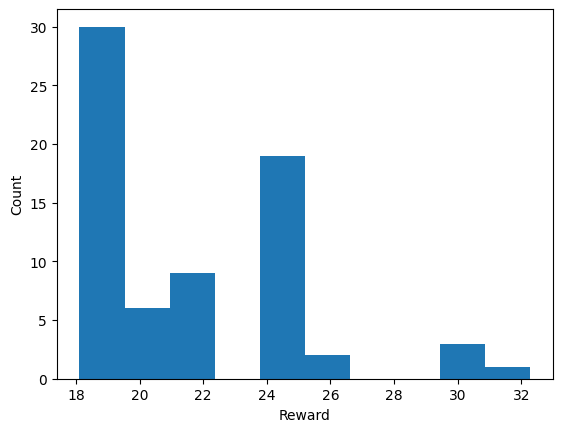

In [14]:
plot_reward_dist(env)

## Plot complexity, loss, and reward trend ##

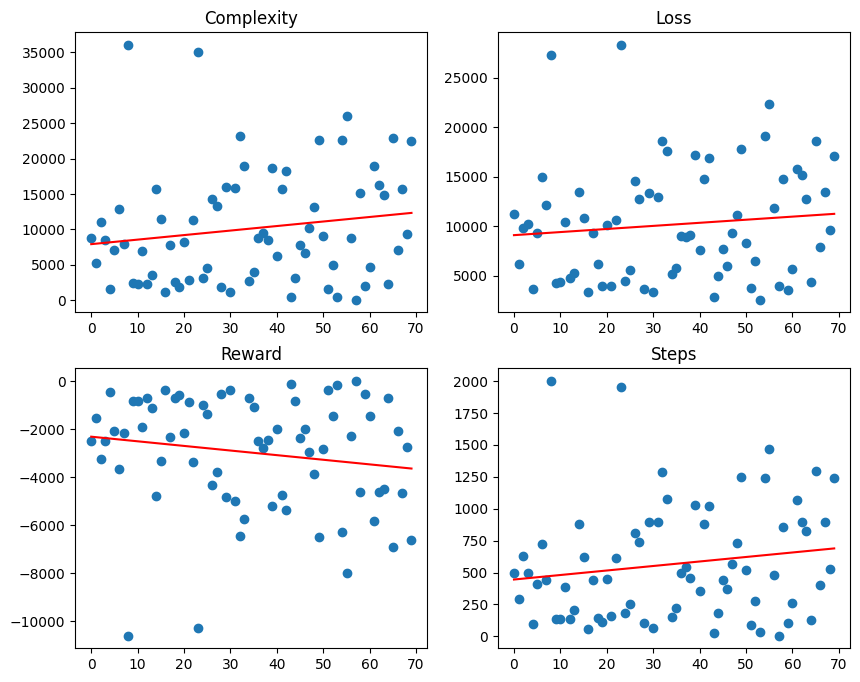

In [15]:
plot_trends(env)

## Run trained agent in eval mode ##

In [9]:
agent.train(10, eval=True)

INFO - 2023-04-21 07:32:28,750 [base.py:214] : Running training routine for 10 episodes in eval=True mode.


{'ep': '10  ', 'step': '2338', 'loop_step': '1597', 'complexity': '5.00e+00', 'loss': '4.51e+00', 'reward': '4.00e+00', 'state': '0                   '}: : 0it [03:05, ?it/s] 

KeyboardInterrupt: 

In [18]:
history = env.best_history
best_i = np.argmax(history["reward"])
print(parse_expr(str(history["state"][best_i])))
print(history["reward"][best_i])

-a1/a0
117.0


## Plot reward distribution for trained agent ##

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

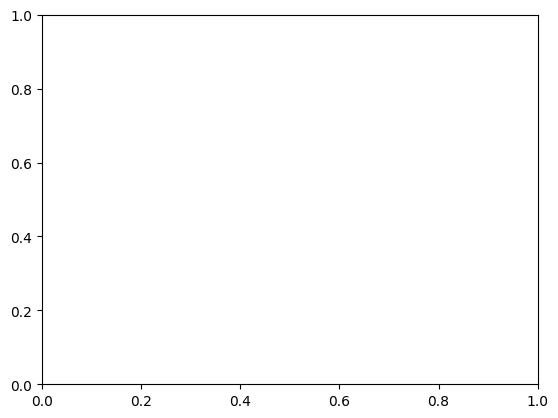

In [22]:
plot_reward_dist(env)

## Render final state graph ##

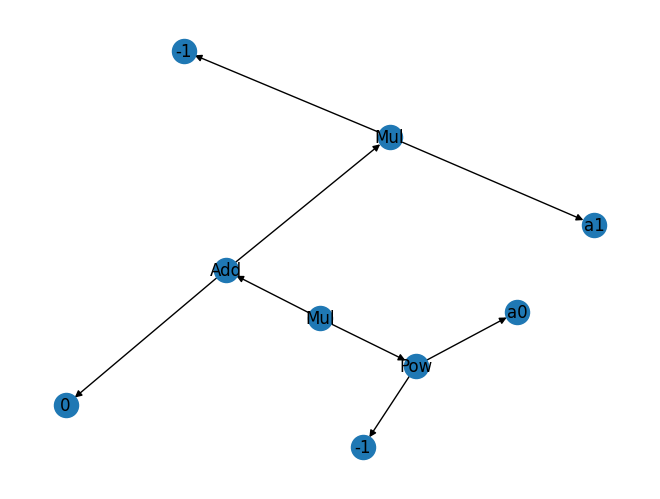

In [20]:
nx.draw(env.state_graph, labels=env.node_labels)

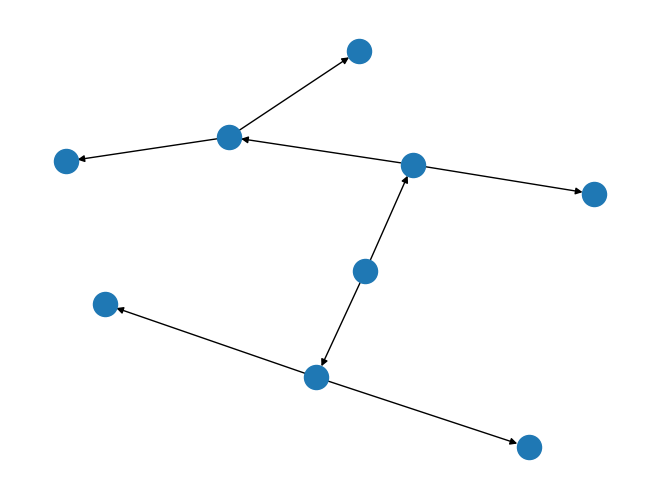

In [25]:
nx.draw(utilities.to_graph(env.history[9]["state"][-1], env.feature_dict))

## Run new Agent in eval mode ##

In [150]:
env = Env(order=2)
agent = AgentGCN(env, device="cuda:0")
agent.train(30, eval=True)

INFO - 2023-04-17 13:10:35,160 [algebraic.py:112] : Initializing environment with order=2, |S| = 11 x 64 = 704
INFO - 2023-04-17 13:10:35,163 [gcn.py:37] : Initialized Agent with device cuda:0
INFO - 2023-04-17 13:10:35,169 [base.py:298] : Running training routine for 30 episodes in eval=True mode.
INFO - 2023-04-17 13:10:35,194 [history.py:76] : 
{'ep': 0, 'step': 1, 'complexity': 14.0, 'loss': 'nan', 'reward': '-8.000e+00', 'state': 1/a1, 'approx': a0/a1 + a1}
INFO - 2023-04-17 13:10:35,196 [base.py:347] : 
Solver terminated after 3 steps: total_reward = -1.700e+01, mean_loss = nan, state = 1/a1
INFO - 2023-04-17 13:10:35,306 [history.py:76] : 
{'ep': 1, 'step': 8, 'complexity': 18.0, 'loss': 'nan', 'reward': '-4.000e+00', 'state': a0 - a1, 'approx': a0*(a0 - a1) + a1}
INFO - 2023-04-17 13:10:35,309 [base.py:347] : 
Solver terminated after 8 steps: total_reward = -1.700e+01, mean_loss = nan, state = a0 - a1
INFO - 2023-04-17 13:10:35,344 [history.py:76] : 
{'ep': 2, 'step': 11, 'comp

## Plot reward distribution for untrained agent ##

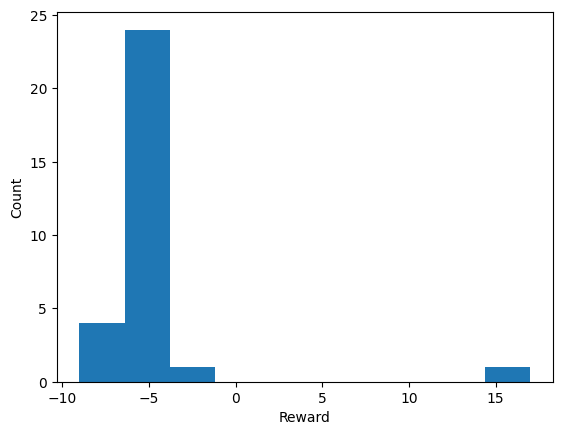

In [151]:
plot_reward_dist(env)